In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [2]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        self.num_states = 2
        self.num_signals = 2
        
        # Minibatch size
        self.batch_size = 2**15
        self.num_menus = 1000

        # Opt params
        self.lr = 1e-3        
        self.pi_temp = 0.2
        self.u_temp = 0.005
                
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 20000 
        self.print_iter = 1000
        
        self.device = "cuda"
        
        self.tst_num_batches = 1000
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)
device = "cuda"

# Utils
def torch_var(x): return torch.tensor(x, device = cfg.device)
def numpy_var(x): return x.detach().cpu().numpy()

In [3]:
class RochetNet(torch.nn.Module):
    def __init__(self, cfg):
        super(RochetNet, self).__init__()
        self.num_menus = cfg.num_menus
        self.num_states = cfg.num_states
        self.num_signals = cfg.num_signals
        self.device = cfg.device
        
        self.pi_temp_inv = torch.tensor(1.0/cfg.pi_temp).to(device)
        self.u_temp_inv = torch.tensor(1.0/cfg.u_temp).to(device)
        
        #  Experiments and payments
        self.pi = torch.empty((self.num_menus, self.num_states, self.num_signals), device = self.device, requires_grad = True)
        self.pay = torch.empty((self.num_menus), device = self.device, requires_grad = True)
        
        # For IR constraints
        self.pi_0 = torch.empty(1, self.num_states, self.num_signals).to(self.device)
        self.pay_0 = torch.empty(1).to(self.device)
        
        # Initialization
        self.reset_parameters()
        
        
    def reset_parameters(self):
        
        # Initialize pi and pay
        nn.init.uniform_(self.pi.data, -1.0, 1.0)
        nn.init.zeros_(self.pay.data)
                
        # Initialize IR menu
        nn.init.ones_(self.pi_0.data)
        nn.init.zeros_(self.pay_0.data)
        self.make_responsive()
        
    def make_responsive(self):
        
        pi = numpy_var(self.pi)
        for i in range(len(pi)):
            _, col_ind = linear_sum_assignment(pi[i], True)
            pi[i] = pi[i][:, col_ind]
        self.pi = torch.tensor(pi, device = self.device, requires_grad = True)
        
    def delete_duplicates(self):
        
        pi_menu, pay_menu = self.get_menu()
        pi_menu = numpy_var(pi_menu[:-1])
        pay_menu = numpy_var(pay_menu[:-1])

        # Sort by prices
        pi_menu = np.round(pi_menu, 4)
        sort_idx = np.argsort(pay_menu)
        pi_menu, pay_menu = pi_menu[sort_idx], pay_menu[sort_idx]

        # Select unique
        _, unique_idx = np.unique(pi_menu, axis = 0, return_index = True)
        pi, pay = numpy_var(self.pi), numpy_var(self.pay)
        pi, pay = pi[unique_idx], pay[unique_idx]
        prev_num_menus = self.num_menus
        self.num_menus = len(unique_idx)
        
        self.pi = torch.tensor(pi, device = self.device, requires_grad = True)
        self.pay = torch.tensor(pay, device = self.device, requires_grad = True)
        print("Updated num_menus from %d --->: %d"%(prev_num_menus, self.pi.shape[0]))
        
    def get_menu(self):
        pi_menu = F.softmax(self.pi_temp_inv * torch.cat([self.pi, self.pi_0]), dim = -1)
        pay_menu = torch.cat([self.pay, self.pay_0])
        return pi_menu, pay_menu
    
    def forward(self, theta):
        pi_menu, pay_menu = self.get_menu()
        utility = torch.max(theta[:, None, :, None] * pi_menu, axis = -2)[0].sum(axis = -1) - pay_menu[None, :]
        menu_idx = F.softmax( self.u_temp_inv * utility, dim = -1)
        rev = menu_idx * pay_menu
        return rev.sum(axis = -1)
    
    def compute_mechanism(self, theta):
        pi_menu, pay_menu = self.get_menu()
        utility = torch.max(theta[:, None, :, None] * pi_menu, axis = -2)[0].sum(axis = -1) - pay_menu[None, :]
        menu_idx = torch.argmax(utility, axis = -1)
        return pi_menu[menu_idx], pay_menu[menu_idx]
        
# Take care of u(theta) = \max {theta}

In [4]:
def sample_batch(batch_size):
    T1 = np.random.dirichlet([8, 30], batch_size)
    T2 = np.random.dirichlet([60, 30], batch_size)
    mask = np.random.binomial(1, 0.50, size = (batch_size,1))
    return mask * T1 + (1 - mask) * T2

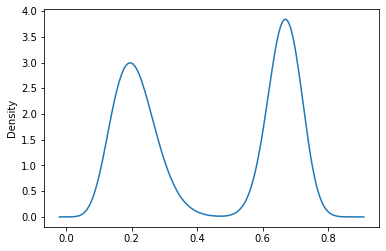

In [5]:
import seaborn as sns
n_samples = 1000000
data = sample_batch(n_samples)[:,0]
sns.kdeplot(data)

In [6]:
net = RochetNet(cfg).to(device)
opt = torch.optim.RMSprop([net.pi, net.pay], lr = 1e-3)
it = 1

In [7]:
import time
tic = time.time()
                                  
while it <= cfg.max_iter:
    
    opt.zero_grad()
    theta = torch_var(sample_batch(cfg.batch_size))
    rev = net(theta).mean()
    loss = -rev
    loss.backward()   
    opt.step()
    
    if it % cfg.print_iter == 0:
        print("[Iter: %d], [Time Elapsed: %.2fs], [Revenue: %.4f]"%(it, time.time() - tic, rev.item()))
    
    if it % 1000 == 0:
        
        # Delete duplicates
        net.delete_duplicates()
        
        # Delete unused menus
        used_menus = torch_var(np.zeros((net.pi.shape[0] + 1)))
        with torch.no_grad():
            pi_menu, pay_menu = net.get_menu()
            for _ in range(cfg.tst_num_batches):
                theta = torch_var(sample_batch(cfg.batch_size))
                utility = torch.max(theta[:, None, :, None] * pi_menu, axis = -2)[0].sum(axis = -1) - pay_menu[None, :]
                menu_idx = F.softmax(net.u_temp_inv * utility, dim = -1)
                menu_idx.data[menu_idx.data < 0.001] = 0.0
                used_menus += menu_idx.sum(axis = 0)

            used_menus = used_menus/(cfg.tst_num_batches * cfg.batch_size)
    
            net.pi = net.pi[used_menus[:-1] > 1e-3]
            net.pay = net.pay[used_menus[:-1] > 1e-3]
        
        net.pi.requires_grad = True
        net.pay.requires_grad = True
        net.num_menus = net.pi.shape[0]
        print("Deleted unused menus. Current: %d"%(net.num_menus))
        
        opt = torch.optim.RMSprop([net.pi, net.pay], lr = 1e-3)
        
    it += 1

[Iter: 1000], [Time Elapsed: 33.80s], [Revenue: 0.1830]
Updated num_menus from 1000 --->: 845
Deleted unused menus. Current: 153
[Iter: 2000], [Time Elapsed: 60.83s], [Revenue: 0.1835]
Updated num_menus from 153 --->: 7
Deleted unused menus. Current: 7
[Iter: 3000], [Time Elapsed: 94.04s], [Revenue: 0.1704]
Updated num_menus from 7 --->: 3
Deleted unused menus. Current: 3
[Iter: 4000], [Time Elapsed: 131.67s], [Revenue: 0.1675]
Updated num_menus from 3 --->: 2
Deleted unused menus. Current: 2
[Iter: 5000], [Time Elapsed: 167.42s], [Revenue: 0.1652]
Updated num_menus from 2 --->: 2
Deleted unused menus. Current: 2
[Iter: 6000], [Time Elapsed: 204.39s], [Revenue: 0.1659]
Updated num_menus from 2 --->: 2
Deleted unused menus. Current: 2
[Iter: 7000], [Time Elapsed: 236.24s], [Revenue: 0.1655]
Updated num_menus from 2 --->: 2
Deleted unused menus. Current: 2
[Iter: 8000], [Time Elapsed: 265.39s], [Revenue: 0.1657]
Updated num_menus from 2 --->: 2
Deleted unused menus. Current: 2
[Iter: 900

In [8]:
with torch.no_grad():
    test_revenue = 0.0
    for _ in range(cfg.tst_num_batches):
        theta = torch_var(sample_batch(cfg.batch_size))
        test_revenue += net.compute_mechanism(theta)[1].mean().item()
    test_revenue = test_revenue/cfg.tst_num_batches
    print("[Test Revenue: %.4f]"%(test_revenue))

[Test Revenue: 0.1671]


In [9]:
pi_menu, pay_menu = net.get_menu()

In [10]:
pi_menu, pay_menu

(tensor([[[    0.7720,     0.2280],
          [    0.0000,     1.0000]],
 
         [[    1.0000,     0.0000],
          [    0.0000,     1.0000]],
 
         [[    0.5000,     0.5000],
          [    0.5000,     0.5000]]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([0.1340, 0.2556, 0.0000], device='cuda:0', grad_fn=<CatBackward0>))

In [11]:
D = 201
theta = np.zeros((D, 2))
t = np.linspace(0, 1, D)
theta[:, 0] = t
theta[:, 1] = 1 - t
theta = torch_var(theta)
pi, pay = net.compute_mechanism(theta)
PI, PAY = numpy_var(pi), numpy_var(pay)

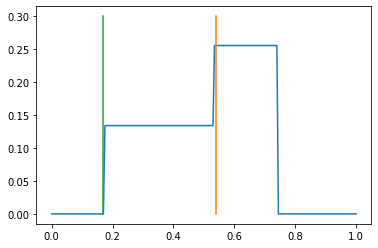

In [12]:
plt.plot(t, PAY)
plt.plot([0.54, 0.54], [0, 0.3])
plt.plot([0.17, 0.17], [0, 0.3])